In [1]:
import re 
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from analytics_utils.bigquery_utils import get_bq_client, BigQuery
import matplotlib.pyplot as plt
from collections import Counter

# Functions 

In [2]:
STAGE_MAP = {
    'New': 1, 'Review': 2, 'Marked Relevant': 4, 
    'Opened': 2, 'Clicked': 2, 'Delivered': 4, 
    'Suppressed': 3, 'Dismissed': 3
}

REVERSE_STAGE_MAP = {
    1: 'New',
    2: 'Review',
    3: 'Dismissed',
    4: 'Marked Relevant'
}

DIM_MAP = {
    'Client': "fetch_recommendation_activity_customer", 
    'Client Industry': "Industry", 
    'Req Seniority': "dim_req_required_seniority_level", 
    'Req Top Category': "dim_req_top_category_calculated"
}

PATTERN_DELETE = r'(?=.+posit.+fill.+)|(?=.+posit.+interna.+)|(?=.+terna.+nly.+)|(?=.+interna.+fill.+)|(?=.+cand.+not.+interested.+)|(?=.+not.+reach.+)|(?=.+reach.+not.+)|(?=.+urrent.+employ.+)|(?=.*\bprocess\b.*\banother\b.*\breq\b)'

REASONS_TO_FILTER = {
    'other: Position will be filled internally ',
    'Candidate invited to apply',
    'In process in another req ',
    'Current Employee',
    'other: Position filled',
    'other: Internal only',
    'Qualified but candidate not interested at this time',
    
}

REASONS_TO_FILTER = {x.lower().strip() for x in REASONS_TO_FILTER}

def check_id(user_id):
    if user_id:
        if 'test' in user_id:
            return False
        elif str(user_id).endswith('-1'):
            return False
    return True

client_industry = pd.read_excel('planhat-companies-Oct-29-2023.xlsx')

In [3]:
def get_dataframe(from_date, to_date, account=None):
    db_client = get_bq_client('production')
    sql = f"""
        SELECT
            fact_recommendation_status_history.analytics_fetch_status_bucket  AS fact_recommendation_status_history_fetch_bucket,
            fetch_recommendation_activity.req_id  AS fetch_recommendation_activity_req_id,
            fetch_recommendation_activity.talent_id  AS fetch_recommendation_activity_talent_id,
            fact_recommendation_status_history.reason  AS fact_recommendation_status_history_reason,
            (DATE(fact_recommendation_status_history.status_ts )) AS fact_recommendation_status_history_status_at_date,
            fetch_recommendation_activity.customer  AS fetch_recommendation_activity_customer,
            dim_req.required_seniority_level  AS dim_req_required_seniority_level,
            dim_req.top_category  AS dim_req_top_category_calculated,
            fact_recommendation_status_history.user_id  AS fact_recommendation_status_history_user_id
        FROM `hs-analytics.all_customers.dwh_hs_dim_recommendation`
             AS fetch_recommendation_activity
        LEFT JOIN `hs-analytics.all_customers.dwh_hs_fact_recommendation_status_history`
             AS fact_recommendation_status_history ON fetch_recommendation_activity.key = fact_recommendation_status_history.recommendation_key
            and fetch_recommendation_activity.customer = fact_recommendation_status_history.customer
        FULL OUTER JOIN `hs-analytics.all_customers.dwh_hs_dim_req`
             AS dim_req ON dim_req.key = fetch_recommendation_activity.req_key
            and dim_req.customer = fetch_recommendation_activity.customer
        WHERE (fact_recommendation_status_history.analytics_fetch_status_bucket ) IN ('Dismissed', 'Marked Relevant', 'Review') 
         --   AND fetch_recommendation_activity.customer = "{account}"
            AND ((( fact_recommendation_status_history.status_ts  ) >= (TIMESTAMP("{str(from_date)}")) 
            AND ( fact_recommendation_status_history.status_ts  ) < (TIMESTAMP("{str(to_date)}")))) 
            AND (fetch_recommendation_activity.customer not in ( 'princeton',
                 'arizona_wd_staging',
                 'antigua',
                 'havana',
                 'seoul_icims',
                 'arizona' ))
        GROUP BY
            1,
            2,
            3,
            4,
            5,
            6,
            7,
            8,
            9
    """
    job_result = db_client.execute(sql)
    df = job_result['query_reults'].to_dataframe()
    df.to_csv('cache_dump.csv', index=None)
    df['Date'] = pd.to_datetime(df['fact_recommendation_status_history_status_at_date'])
    return df

In [4]:
def prepare_df(df):
    calc_df = df.copy()

    calc_df['Date'] = pd.to_datetime(calc_df['fact_recommendation_status_history_status_at_date'])
    for period in ('M', 'W', '2W'):
        calc_df[f'Period {period}'] = calc_df['Date'].dt.to_period(period)

    calc_df['bucket_code'] = calc_df['fact_recommendation_status_history_fetch_bucket'].map(STAGE_MAP)
    calc_df['pair_id'] = calc_df['fetch_recommendation_activity_req_id'].fillna('nan') + '_' + calc_df['fetch_recommendation_activity_talent_id'].fillna('nan')

    leads_to_filter = set(calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['pair_id'].values)


    calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['bucket_code'] = STAGE_MAP['Marked Relevant']

    calc_df = calc_df[
        (~calc_df['pair_id'].isin(leads_to_filter)) & 
        (calc_df['fact_recommendation_status_history_user_id'].fillna('').apply(check_id))
    ]
    grouped_df = calc_df.groupby(
        ['pair_id'], as_index=False
    ).agg(
        {"bucket_code": "max",
         'fetch_recommendation_activity_req_id': 'first',
         'fetch_recommendation_activity_talent_id': 'first',
         'fetch_recommendation_activity_customer': 'first',
         'fact_recommendation_status_history_user_id': 'first',
         'Date': 'max',
         'Period M': 'max',
         'Period W': 'max',
         'Period 2W': 'max',     
         'dim_req_top_category_calculated': 'first',
         'dim_req_required_seniority_level': 'first',
        })

    grouped_df['Max Status Bucket'] = grouped_df['bucket_code'].map(REVERSE_STAGE_MAP)
    grouped_df = pd.concat([grouped_df, pd.get_dummies(grouped_df['Max Status Bucket'])], axis=1)
    grouped_df = grouped_df.dropna(subset=['Max Status Bucket'])

    client_industry['Account Name'] = client_industry['Account Name'].str.lower()
    grouped_df = pd.merge(grouped_df, client_industry, 
                          left_on='fetch_recommendation_activity_customer', 
                          right_on='Account Name', how='left')
    return grouped_df

In [5]:
def calc_rate(ddf):
    return ddf['Marked Relevant'].sum() / (ddf['Marked Relevant'] + ddf['Dismissed'] + ddf['Review']).sum()

# Overall rates

In [6]:
raw_df = get_dataframe(date(2023, 9, 1), date(2024, 3, 1))
raw_df.shape

(343075, 10)

In [7]:
ACCOUNT = 'dallas'
TEST_DATE = datetime(2023, 12, 4)
prep_df = prepare_df(raw_df[raw_df['fetch_recommendation_activity_customer'] == ACCOUNT])
prep_df['user_cat_pair'] = prep_df['fact_recommendation_status_history_user_id'] + prep_df['dim_req_top_category_calculated']
prep_df.shape

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_69381/3353077257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_df[


(5167, 19)

In [8]:
#prep_df = prep_df[prep_df['Date'] < datetime(2023, 10, 1)]

In [9]:
after_df = prep_df[prep_df['Date'] > TEST_DATE]
before_df= prep_df[prep_df['Date'] < TEST_DATE]

In [10]:
calc_rate(before_df), calc_rate(after_df)

(0.04844961240310078, 0.07486979166666667)

In [11]:
relevant_pairs = set(after_df['user_cat_pair'].value_counts().loc[lambda x: x > 10].index) & set(before_df['user_cat_pair'].value_counts().loc[lambda x: x > 10].index)
len(relevant_pairs)

20

In [12]:
filtered_before_df = before_df[before_df['user_cat_pair'].isin(relevant_pairs)].copy()
filtered_before_df.shape

(1431, 19)

In [13]:
filtered_after_df = after_df[after_df['user_cat_pair'].isin(relevant_pairs)].copy()
filtered_after_df.shape

(877, 19)

In [14]:
calc_rate(filtered_before_df), calc_rate(filtered_after_df)

(0.02166317260656883, 0.06271379703534778)

# Adjusted rates

In [15]:
filtered_before_df['algo'] = 'BEFORE'
filtered_after_df['algo'] = 'AFTER'
new_df = pd.concat([filtered_before_df, filtered_after_df])
new_df.shape

(2308, 20)

In [37]:
gb = ['fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated', 'algo']
gdf = new_df.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']]

In [38]:
gdf = gdf[(gdf['Marked Relevant'] > 1) & (gdf['Dismissed'] > 1)]

In [39]:
gdf['total'] = gdf['Marked Relevant'] + gdf['Dismissed'] + gdf['Review']
gdf['rate'] = gdf['Marked Relevant'] / gdf['total']

In [40]:
gdf.reset_index().groupby('algo')[['rate']].mean()

,rate
algo,
AFTER,0.271890
BEFORE,0.122092


In [41]:
udf = gdf.unstack().dropna()
udf['ratio'] = (udf[('rate', 'AFTER')] / udf[('rate', 'BEFORE')])

In [42]:
udf['ratio'].mean()

1.7718535737766505

In [43]:
udf

Marked Relevant  \
algo                                                                                 AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated                   
DEL15                                      IT_&_Software_Development                   4.0   
DEL456                                     IT_&_Software_Development                   7.0   
DEL84                                      IT_&_Software_Development                  12.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL15                                      IT_&_Software_Development         13.0   
DEL456                                     IT_&_Software_Development          6.0   
DEL84                                      IT_&_Software_Development          5.0   

                                                                           Dismissed  \
algo                                                                           AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated             
DEL15                                      IT_&_Software_Development             5.0   
DEL456                                     IT_&_Software_Development            25.0   
DEL84                                      IT_&_Software_Development            44.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL15                                      IT_&_Software_Development         43.0   
DEL456                                     IT_&_Software_Development         17.0   
DEL84                                      IT_&_Software_Development         43.0   

                                                                           Review  \
algo                                                                        AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL15                                      IT_&_Software_Development          4.0   
DEL456                                     IT_&_Software_Development          0.0   
DEL84                                      IT_&_Software_Development          0.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL15                                      IT_&_Software_Development         11.0   
DEL456                                     IT_&_Software_Development         17.0   
DEL84                                      IT_&_Software_Development          5.0   

                                                                           total  \
algo                                                                       AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated         
DEL15                                      IT_&_Software_Development        13.0   
DEL456                                     IT_&_Software_Development        32.0   
DEL84                                      IT_&_Software_Development        56.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL15                                      IT_&_Software_Development         67.0   
DEL456                                     IT_&_Software_Development         40.0   
DEL84  

In [44]:
udf.shape

(3, 11)

In [45]:
udf.sort_values('ratio')

Marked Relevant  \
algo                                                                                 AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated                   
DEL456                                     IT_&_Software_Development                   7.0   
DEL15                                      IT_&_Software_Development                   4.0   
DEL84                                      IT_&_Software_Development                  12.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL456                                     IT_&_Software_Development          6.0   
DEL15                                      IT_&_Software_Development         13.0   
DEL84                                      IT_&_Software_Development          5.0   

                                                                           Dismissed  \
algo                                                                           AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated             
DEL456                                     IT_&_Software_Development            25.0   
DEL15                                      IT_&_Software_Development             5.0   
DEL84                                      IT_&_Software_Development            44.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL456                                     IT_&_Software_Development         17.0   
DEL15                                      IT_&_Software_Development         43.0   
DEL84                                      IT_&_Software_Development         43.0   

                                                                           Review  \
algo                                                                        AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL456                                     IT_&_Software_Development          0.0   
DEL15                                      IT_&_Software_Development          4.0   
DEL84                                      IT_&_Software_Development          0.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL456                                     IT_&_Software_Development         17.0   
DEL15                                      IT_&_Software_Development         11.0   
DEL84                                      IT_&_Software_Development          5.0   

                                                                           total  \
algo                                                                       AFTER   
fact_recommendation_status_history_user_id dim_req_top_category_calculated         
DEL456                                     IT_&_Software_Development        32.0   
DEL15                                      IT_&_Software_Development        13.0   
DEL84                                      IT_&_Software_Development        56.0   

                                                                                   \
algo                                                                       BEFORE   
fact_recommendation_status_history_user_id dim_req_top_category_calculated          
DEL456                                     IT_&_Software_Development         40.0   
DEL15                                      IT_&_Software_Development         67.0   
DEL84  

In [46]:
udf['ratio'].describe()

count    3.000000
mean     1.771854
std      0.437314
min      1.458333
25%      1.522066
50%      1.585799
75%      1.928614
max      2.271429
Name: ratio, dtype: float64

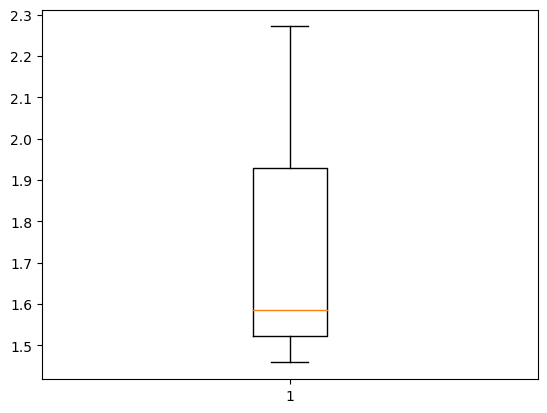

In [47]:
_ = plt.boxplot(udf['ratio'].dropna())

# Bootstrap

In [48]:
ratios = []
for i in range(1000):
    sample_df = new_df.sample(n=len(new_df), replace=True)
    sample_gdf = sample_df.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']]
    sample_gdf = sample_gdf[(sample_gdf['Marked Relevant'] > 1) & (sample_gdf['Dismissed'] > 1)]
    sample_gdf['total'] = sample_gdf['Marked Relevant'] + sample_gdf['Dismissed'] + sample_gdf['Review']
    sample_gdf['rate'] = sample_gdf['Marked Relevant'] / sample_gdf['total']
    sample_udf = sample_gdf.unstack().dropna()
    sample_udf['ratio'] = (sample_udf[('rate', 'AFTER')] / sample_udf[('rate', 'BEFORE')])
    ratios.append(sample_udf['ratio'].mean())

In [49]:
print('Ratio:', np.mean(ratios), np.percentile(ratios, [2.5, 97.5]))

Ratio: 2.7363529645417786 [1.12346058 5.37106929]


# All Accounts

In [29]:
all_df = prepare_df(raw_df)

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_69381/3353077257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_df[


In [30]:
all_df['total'] = all_df['Dismissed'] + all_df['Marked Relevant'] + all_df['Review']

In [31]:
all_df.head()

,pair_id,bucket_code,fetch_recommendation_activity_req_id,fetch_recommendation_activity_talent_id,fetch_recommendation_activity_customer,fact_recommendation_status_history_user_id,Date,Period M,Period W,Period 2W,dim_req_top_category_calculated,dim_req_required_seniority_level,Max Status Bucket,Dismissed,Marked Relevant,Review,Account Name,Industry,total
0,AAL68787_897192c2-4c15-4e04-a330-d3b1afa688c4,2,AAL68787,897192c2-4c15-4e04-a330-d3b1afa688c4,atlanta,AAL-6b7dc015-648c-4ff9-9530-4b0c6876637f-16905...,2023-09-21,2023-09,2023-09-18/2023-09-24,2023-09-18/2023-09-24,Administrative,entry_level,Review,0,0,1,atlanta,Airlines,1
1,AAL69166_0c9a7e65-f386-47d8-81e0-f792130eac3b,2,AAL69166,0c9a7e65-f386-47d8-81e0-f792130eac3b,atlanta,AAL-ac72b218-0ea6-40fc-bfd8-5225e2b0c76d-16956...,2023-09-25,2023-09,2023-09-25/2023-10-01,2023-09-25/2023-10-01,Editorial_&_Content,junior,Review,0,0,1,atlanta,Airlines,1
2,AAL69166_4340cbb1-f120-4699-825e-d15aa7302812,2,AAL69166,4340cbb1-f120-4699-825e-d15aa7302812,atlanta,AAL-ac72b218-0ea6-40fc-bfd8-5225e2b0c76d-16956...,2023-09-25,2023-09,2023-09-25/2023-10-01,2023-09-25/2023-10-01,Editorial_&_Content,junior,Review,0,0,1,atlanta,Airlines,1
3,AAL69166_8153921d-4ddb-4ca2-9ed2-715455bf0643,2,AAL69166,8153921d-4ddb-4ca2-9ed2-715455bf0643,atlanta,AAL-ac72b218-0ea6-40fc-bfd8-5225e2b0c76d-16956...,2023-09-25,2023-09,2023-09-25/2023-10-01,2023-09-25/2023-10-01,Editorial_&_Content,junior,Review,0,0,1,atlanta,Airlines,1
4,AAL69166_ab4ab8b8-d8ea-4c9d-a87f-cca462084e64,2,AAL69166,ab4ab8b8-d8ea-4c9d-a87f-cca462084e64,atlanta,AAL-ac72b218-0ea6-40fc-bfd8-5225e2b0c76d-16956...,2023-09-25,2023-09,2023-09-25/2023-10-01,2023-09-25/2023-10-01,Editorial_&_Content,junior,Review,0,0,1,atlanta,Airlines,1


In [32]:
all_df.groupby(['fetch_recommendation_activity_customer', 'Period W'])[['total']].sum().reset_index().groupby('fetch_recommendation_activity_customer').mean().sort_values('total')

,total
fetch_recommendation_activity_customer,
ebina,2.000000
atlanta,4.470588
verona,4.900000
hawaii,6.615385
zagreb,6.846154
busan,8.933333
sofia,9.100000
napa,9.750000
donegal,11.238095


In [33]:
all_df.groupby(['fetch_recommendation_activity_customer'])['total'].sum().sort_values()

fetch_recommendation_activity_customer
ebina                        2.0
verona                      49.0
delhi                       53.0
atlanta                     76.0
napa                        78.0
hawaii                      86.0
zagreb                      89.0
sofia                       91.0
busan                      134.0
ibiza_smartrecruiters      150.0
cairo                      207.0
izmir                      230.0
donegal                    236.0
antwerp                    270.0
awasa                      304.0
nashville                  468.0
austin_orc                 478.0
siena                      545.0
philly                     693.0
exeter                     722.0
santiago                   775.0
aden                       877.0
essex                      898.0
alabama                    993.0
brooklyn                  1095.0
berlin                    1112.0
lima                      1185.0
colorado                  1288.0
nairobi                   1292.0
amma

In [34]:
x = all_df.groupby(['fetch_recommendation_activity_customer', 'Period W'])[['total']].sum().reset_index().groupby('fetch_recommendation_activity_customer').agg(['mean', 'std']).reset_index()

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_69381/2695405306.py:1: FutureWarning: ['Period W'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  x = all_df.groupby(['fetch_recommendation_activity_customer', 'Period W'])[['total']].sum().reset_index().groupby('fetch_recommendation_activity_customer').agg(['mean', 'std']).reset_index()


In [35]:
accounts = [
'antalya',
'porto',
'athens',
'moscow',
'seattle',
'cancun',
'indiana',
'arizona_wd',
    'oxford'
]

In [36]:
x[x['fetch_recommendation_activity_customer'].isin(accounts)]

fetch_recommendation_activity_customer        total            
                                                  mean         std
3                                 antalya  1380.708333  641.831922
6                              arizona_wd   213.375000  112.710793
7                                  athens   397.041667  212.443646
16                                 cancun   176.458333  128.468226
31                                indiana   254.333333   94.087687
37                                 moscow   333.708333  182.337594
41                                 oxford   480.055556  362.251208
44                                  porto   845.375000  476.786053
46                                seattle   338.416667  226.570445